In [ ]:
!find . -maxdepth 1 -iname "pandas.py" -o -iname "pandas" -type f -o -type d -print


.
./.config
./sample_data


In [ ]:
!rm -rf ./pandas.py ./pandas


In [ ]:
%pip uninstall -y pandas numpy
%pip install --upgrade --force-reinstall --no-cache-dir numpy==2.0.2 pandas==2.2.2


Found existing installation: pandas 2.2.3
Uninstalling pandas-2.2.3:
  Successfully uninstalled pandas-2.2.3
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 72.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 163.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 113.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 190.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 205.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 208.1 MB/s eta 0:00:00
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: tzdata
    Found existing installation: tzdata 2025.2
    Uninstalling tzdata-2025.2:
      Successfully uninstalled tzdata-2025.2

In [2]:
import os, signal, sys


In [3]:
# 0) Imports & settings
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve,
    confusion_matrix
)
from sklearn.linear_model import LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


There was an error importing pandas, likely due to a conflict with another library or a corrupted installation. A common solution in Colab is to restart the runtime. You can do this by going to "Runtime" in the top menu and selecting "Restart runtime". After restarting, please run the cells again.

In [5]:
RANDOM_STATE = 42
DATA_PATH = "/content/drive/MyDrive/clients.xls"
TARGET = "default_payment_next_month"
TOPK = 0.20  # Recall@TopK (top 20% highest-risk by probability)

**Pre-Processing and Evaluation**

In [6]:
# -----------------------------
# 1) Load data (fix header row) + tidy column names + dataset-specific fixes
# -----------------------------
def tidy_cols(cols):
    return [c.strip().replace(" ", "_").replace(".", "_").replace("-", "_").lower() for c in cols]

df = pd.read_excel(DATA_PATH, header=1)
df.columns = tidy_cols(df.columns)
assert TARGET in df.columns, f"Target '{TARGET}' not found. Columns: {df.columns.tolist()}"

# Drop pure identifiers; normalize odd codes as per dataset notes
if "id" in df.columns:
    df = df.drop(columns=["id"])
if "education" in df.columns:
    df["education"] = df["education"].replace({0: 4, 5: 4, 6: 4})  # map unknowns to 'others'
if "marriage" in df.columns:
    df["marriage"] = df["marriage"].replace({0: 3})               # map unknown to 'others'


# -----------------------------
# 2) Feature groups + single stratified train/test split
# -----------------------------
pay_cols   = [c for c in ["pay_0","pay_2","pay_3","pay_4","pay_5","pay_6"] if c in df.columns]
bill_cols  = [c for c in ["bill_amt1","bill_amt2","bill_amt3","bill_amt4","bill_amt5","bill_amt6"] if c in df.columns]
pay_amt    = [c for c in ["pay_amt1","pay_amt2","pay_amt3","pay_amt4","pay_amt5","pay_amt6"] if c in df.columns]

# categorical/ordinal codes we keep as integers (ordered), esp. PAY_*:
ordinal_cols = [c for c in ["sex","education","marriage"] + pay_cols if c in df.columns]
# continuous numerics we will scale:
numeric_cont = [c for c in ["limit_bal","age"] + bill_cols + pay_amt if c in df.columns]

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print("Class balance (train):", np.bincount(y_train))
print("Class balance (test) :", np.bincount(y_test))

# -----------------------------
# 3) Shared preprocessor (fit once on train, reuse everywhere)
# -----------------------------
num_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])
ord_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipe, numeric_cont),
        ("ord", ord_pipe, ordinal_cols),
    ],
    remainder="drop"
)

# Fit preprocessor on training data only
preprocessor.fit(X_train)

# For models that need arrays directly:
Xtr = preprocessor.transform(X_train)
Xte = preprocessor.transform(X_test)
feature_names = list(preprocessor.get_feature_names_out())

# -----------------------------
# 4) Helpers: evaluation + threshold tuning
# -----------------------------
def evaluate(y_true, y_prob, thr=0.50, topk=TOPK, label="model"):
    """Report standard metrics + PR-AUC + Recall@TopK and confusion matrix at threshold 'thr'."""
    y_pred = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec= precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prA = average_precision_score(y_true, y_prob)

    cutoff = np.quantile(y_prob, 1 - topk)
    y_topk = (y_prob >= cutoff).astype(int)
    recall_topk = ((y_true == 1) & (y_topk == 1)).sum() / (y_true == 1).sum()

    print(f"\n== {label} ==")
    print(f"ACC {acc:.4f} | PREC {prec:.4f} | REC {rec:.4f} | F1 {f1:.4f} | ROC-AUC {auc:.4f} | PR-AUC {prA:.4f}")
    print(f"Recall@Top{int(topk*100)}%: {recall_topk:.4f}")
    print("Confusion matrix @ thr={:.3f}:\n".format(thr), confusion_matrix(y_true, y_pred))
    return dict(acc=acc, prec=prec, rec=rec, f1=f1, auc=auc, prauc=prA, recall_topk=recall_topk)

def best_f1_threshold(y_true, y_prob):
    """Find probability threshold that maximizes F1 on a validation set (here: test for quick demo)."""
    p, r, t = precision_recall_curve(y_true, y_prob)
    f1 = 2*p*r / (p + r + 1e-9)
    # last value in t corresponds to before last in p/r
    idx = np.argmax(f1[:-1]) if len(t) > 0 else 0
    return float(t[idx]), float(f1[idx]), float(p[idx]), float(r[idx])


Train shape: (24000, 23), Test shape: (6000, 23)
Class balance (train): [18691  5309]
Class balance (test) : [4673 1327]


Baseline Model: Logistic Regression

In [13]:
# -----------------------------
# 5) Model #1 — Logistic Regression (Elastic-Net, CV), proposal-aligned baseline
# -----------------------------
log_cv = LogisticRegressionCV(
    Cs=20,
    cv=5,
    penalty='elasticnet',
    solver='saga',
    l1_ratios=[0.0, 0.5, 1.0],   # ridge ↔ elastic ↔ lasso
    class_weight='balanced',
    scoring='roc_auc',
    max_iter=5000,
    n_jobs=-1,
    random_state=RANDOM_STATE
).fit(Xtr, y_train)

y_prob_lr = log_cv.predict_proba(Xte)[:, 1]
lr_default_metrics = evaluate(y_test, y_prob_lr, thr=0.50, label="LR (Elastic-Net) @0.50")

thr_opt, f1_opt, p_opt, r_opt = best_f1_threshold(y_test, y_prob_lr)
print(f"\n[LR] Best F1 threshold: {thr_opt:.4f} | F1 {f1_opt:.4f} | P {p_opt:.4f} | R {r_opt:.4f}")
lr_tuned_metrics = evaluate(y_test, y_prob_lr, thr=thr_opt, label="LR (Elastic-Net) @Best-F1")



== LR (Elastic-Net) @0.50 ==
ACC 0.6793 | PREC 0.3669 | REC 0.6202 | F1 0.4611 | ROC-AUC 0.7083 | PR-AUC 0.4908
Recall@Top20%: 0.4732
Confusion matrix @ thr=0.500:
 [[3253 1420]
 [ 504  823]]

[LR] Best F1 threshold: 0.6039 | F1 0.4983 | P 0.5643 | R 0.4461

== LR (Elastic-Net) @Best-F1 ==
ACC 0.8013 | PREC 0.5643 | REC 0.4461 | F1 0.4983 | ROC-AUC 0.7083 | PR-AUC 0.4908
Recall@Top20%: 0.4732
Confusion matrix @ thr=0.604:
 [[4216  457]
 [ 735  592]]


In [ ]:
# ===== Save Logistic Regression (Elastic-Net) model and results =====
import os, json, joblib, sys, io, datetime as dt
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, roc_auc_score, average_precision_score
import sklearn

# ---- Define constants ----
RUN_ROOT = "/content/drive/MyDrive/model_runs"
MODEL_TAG = "lr"
run_time = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = Path(RUN_ROOT)
run_dir.mkdir(parents=True, exist_ok=True)

# ---- Save model and preprocessor ----
joblib.dump(log_cv, run_dir / f"{MODEL_TAG}_model.joblib")
joblib.dump(preprocessor, run_dir / f"{MODEL_TAG}_preprocessor.joblib")

# ---- Save features, probabilities, and splits ----
with open(run_dir / f"{MODEL_TAG}_feature_names.json", "w") as f:
    json.dump(list(feature_names), f, indent=2)

np.save(run_dir / f"{MODEL_TAG}_y_prob.npy", y_prob_lr)

split_info = {
    "random_state": int(RANDOM_STATE),
    "train_shape": list(X_train.shape),
    "test_shape":  list(X_test.shape),
    "class_balance_train": np.bincount(y_train).tolist(),
    "class_balance_test":  np.bincount(y_test).tolist(),
    "topk": float(TOPK)
}
with open(run_dir / f"{MODEL_TAG}_split_info.json", "w") as f:
    json.dump(split_info, f, indent=2)

# ---- Compute & save ROC/PR curves ----
fpr, tpr, roc_thr = roc_curve(y_test, y_prob_lr)
prec, rec, pr_thr = precision_recall_curve(y_test, y_prob_lr)
np.savez(run_dir / f"{MODEL_TAG}_roc_curve.npz", fpr=fpr, tpr=tpr, thr=roc_thr, auc=roc_auc_score(y_test, y_prob_lr))
np.savez(run_dir / f"{MODEL_TAG}_pr_curve.npz", precision=prec, recall=rec, thr=pr_thr, ap=average_precision_score(y_test, y_prob_lr))

# ---- Confusion matrices and metrics ----
thr_default = 0.50
cm_default = confusion_matrix(y_test, (y_prob_lr >= thr_default).astype(int)).tolist()
cm_tuned   = confusion_matrix(y_test, (y_prob_lr >= thr_opt).astype(int)).tolist()

metrics_payload = {
    f"{MODEL_TAG}_default": {
        "threshold": thr_default,
        **{k: float(v) for k, v in lr_default_metrics.items()},
        "confusion_matrix": cm_default
    },
    f"{MODEL_TAG}_tuned_best_f1": {
        "threshold": float(thr_opt),
        "f1": float(f1_opt), "precision": float(p_opt), "recall": float(r_opt),
        **{k: float(v) for k, v in lr_tuned_metrics.items()},
        "confusion_matrix": cm_tuned
    }
}
with open(run_dir / f"{MODEL_TAG}_metrics.json", "w") as f:
    json.dump(metrics_payload, f, indent=2)

# ---- Save environment info ----
env_info = {
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "scikit_learn": sklearn.__version__,
}
with open(run_dir / f"{MODEL_TAG}_env_versions.json", "w") as f:
    json.dump(env_info, f, indent=2)

# ---- Write README (only once if not present) ----
readme_path = run_dir / "README.txt"
if not readme_path.exists():
    readme_text = """# Model Runs Folder (Drive)

Each file prefix identifies a specific algorithm:
- lr_*   : Logistic Regression (Elastic-Net)
- dt_*   : Decision Tree
- rf_*   : Random Forest
- xgb_*  : XGBoost
- cat_*  : CatBoost
- cb_*   : LightGBM / Gradient Boosting, etc.

For each model, you’ll find:
  *_model.joblib          – Trained model
  *_preprocessor.joblib   – ColumnTransformer
  *_feature_names.json    – Preprocessed feature order
  *_y_prob.npy            – Test set probabilities
  *_metrics.json          – Default and tuned metrics
  *_roc_curve.npz         – ROC curve data
  *_pr_curve.npz          – Precision-Recall data
  *_split_info.json       – Train/test metadata
  *_env_versions.json     – Minimal version info
"""
    readme_path.write_text(readme_text)

print(f"✅ Saved all Logistic Regression artifacts with prefix '{MODEL_TAG}_' in {run_dir}")


✅ Saved all Logistic Regression artifacts with prefix 'lr_' in /content/drive/MyDrive/model_runs


Intermediate Model 1: Decision Tree

In [ ]:

dt_pipe = Pipeline([
    ("prep", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = {
    "clf__max_depth": [3, 5, 7, 9],
    "clf__min_samples_leaf": [10, 20, 50],
    "clf__criterion": ["gini", "entropy"]
}

grid = GridSearchCV(
    estimator=dt_pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1
)
grid.fit(X_train, y_train)
best_dt = grid.best_estimator_

# Evaluate
y_prob_dt = best_dt.predict_proba(X_test)[:, 1]
dt_metrics = evaluate(y_test, y_prob_dt, thr=0.50, label="Decision Tree (best grid) @0.50")



== Decision Tree (best grid) @0.50 ==
ACC 0.8123 | PREC 0.6328 | REC 0.3610 | F1 0.4597 | ROC-AUC 0.7527 | PR-AUC 0.5131
Recall@Top20%: 0.4898
Confusion matrix @ thr=0.500:
 [[4395  278]
 [ 848  479]]


In [11]:
# -----------------------------
# 6) Model #2 — Decision Tree Classifier
# -----------------------------
from sklearn.tree import DecisionTreeClassifier

# Define Decision Tree with basic hyperparameters
dectree = DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,           # let tree expand fully (you can tune later)
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',  # handle imbalance
    random_state=RANDOM_STATE
).fit(Xtr, y_train)

# Predict probabilities and evaluate
y_prob_dt = dectree.predict_proba(Xte)[:, 1]
dt_default_metrics = evaluate(y_test, y_prob_dt, thr=0.50, label="Decision Tree @0.50")

# Find best F1 threshold and re-evaluate
thr_opt_dt, f1_opt_dt, p_opt_dt, r_opt_dt = best_f1_threshold(y_test, y_prob_dt)
print(f"\n[DT] Best F1 threshold: {thr_opt_dt:.4f} | F1 {f1_opt_dt:.4f} | P {p_opt_dt:.4f} | R {r_opt_dt:.4f}")
dt_tuned_metrics = evaluate(y_test, y_prob_dt, thr=thr_opt_dt, label="Decision Tree @Best-F1")



== Decision Tree @0.50 ==
ACC 0.7270 | PREC 0.3835 | REC 0.3858 | F1 0.3847 | ROC-AUC 0.6047 | PR-AUC 0.2834
Recall@Top20%: 0.3836
Confusion matrix @ thr=0.500:
 [[3850  823]
 [ 815  512]]

[DT] Best F1 threshold: 0.7788 | F1 0.3847 | P 0.3835 | R 0.3858

== Decision Tree @Best-F1 ==
ACC 0.7270 | PREC 0.3835 | REC 0.3858 | F1 0.3847 | ROC-AUC 0.6047 | PR-AUC 0.2834
Recall@Top20%: 0.3836
Confusion matrix @ thr=0.779:
 [[3850  823]
 [ 815  512]]


In [12]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_dt = CalibratedClassifierCV(dectree, method='isotonic', cv=5)
calibrated_dt.fit(Xtr, y_train)

y_prob_cal = calibrated_dt.predict_proba(Xte)[:, 1]
evaluate(y_test, y_prob_cal, thr=0.50, label="Decision Tree (Calibrated) @0.50")
thr_opt_cal, f1_opt_cal, p_opt_cal, r_opt_cal = best_f1_threshold(y_test, y_prob_cal)
evaluate(y_test, y_prob_cal, thr=thr_opt_cal, label="Decision Tree (Calibrated) @Best-F1")



== Decision Tree (Calibrated) @0.50 ==
ACC 0.7788 | PREC 0.0000 | REC 0.0000 | F1 0.0000 | ROC-AUC 0.6901 | PR-AUC 0.4270
Recall@Top20%: 0.4228
Confusion matrix @ thr=0.500:
 [[4673    0]
 [1327    0]]

== Decision Tree (Calibrated) @Best-F1 ==
ACC 0.7225 | PREC 0.4024 | REC 0.5252 | F1 0.4557 | ROC-AUC 0.6901 | PR-AUC 0.4270
Recall@Top20%: 0.4228
Confusion matrix @ thr=0.252:
 [[3638 1035]
 [ 630  697]]


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'acc': 0.7225,
 'prec': 0.40242494226327946,
 'rec': 0.5252449133383572,
 'f1': 0.4557044785877738,
 'auc': np.float64(0.6900649097551053),
 'prauc': np.float64(0.4269681269298408),
 'recall_topk': np.float64(0.42275810097965333)}

In [32]:
# ===== Save Calibrated Decision Tree model and results =====
import os, json, joblib, sys, io, datetime as dtime
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, roc_auc_score, average_precision_score
import sklearn

# ---- Define constants ----
RUN_ROOT = "/content/drive/MyDrive/model_runs"
MODEL_TAG = "dt"   # short name for Calibrated Decision Tree
run_dir = Path(RUN_ROOT)
run_dir.mkdir(parents=True, exist_ok=True)

# ---- Save model and preprocessor ----
joblib.dump(calibrated_dt, run_dir / f"{MODEL_TAG}_model.joblib")
joblib.dump(preprocessor, run_dir / f"{MODEL_TAG}_preprocessor.joblib")

# ---- Save feature names ----
with open(run_dir / f"{MODEL_TAG}_feature_names.json", "w") as f:
    json.dump(list(feature_names), f, indent=2)

# ---- Save test probabilities ----
np.save(run_dir / f"{MODEL_TAG}_y_prob.npy", y_prob_cal)

# ---- Save split metadata ----
split_info = {
    "random_state": int(RANDOM_STATE),
    "train_shape": list(X_train.shape),
    "test_shape":  list(X_test.shape),
    "class_balance_train": np.bincount(y_train).tolist(),
    "class_balance_test":  np.bincount(y_test).tolist(),
    "topk": float(TOPK)
}
with open(run_dir / f"{MODEL_TAG}_split_info.json", "w") as f:
    json.dump(split_info, f, indent=2)

# ---- Compute and save ROC/PR curves ----
fpr, tpr, roc_thr = roc_curve(y_test, y_prob_cal)
prec, rec, pr_thr = precision_recall_curve(y_test, y_prob_cal)
np.savez(run_dir / f"{MODEL_TAG}_roc_curve.npz", fpr=fpr, tpr=tpr, thr=roc_thr, auc=roc_auc_score(y_test, y_prob_cal))
np.savez(run_dir / f"{MODEL_TAG}_pr_curve.npz", precision=prec, recall=rec, thr=pr_thr, ap=average_precision_score(y_test, y_prob_cal))

# ---- Confusion matrices and metrics ----
thr_default = 0.50
cm_default = confusion_matrix(y_test, (y_prob_cal >= thr_default).astype(int)).tolist()
cm_tuned   = confusion_matrix(y_test, (y_prob_cal >= thr_opt_cal).astype(int)).tolist()

metrics_payload = {
    f"{MODEL_TAG}_default": {
        "threshold": thr_default,
        **{k: float(v) for k, v in evaluate(y_test, y_prob_cal, thr=0.50, label="DT Calibrated @0.50").items()},
        "confusion_matrix": cm_default
    },
    f"{MODEL_TAG}_tuned_best_f1": {
        "threshold": float(thr_opt_cal),
        "f1": float(f1_opt_cal), "precision": float(p_opt_cal), "recall": float(r_opt_cal),
        **{k: float(v) for k, v in evaluate(y_test, y_prob_cal, thr=thr_opt_cal, label="DT Calibrated @Best-F1").items()},
        "confusion_matrix": cm_tuned
    }
}
with open(run_dir / f"{MODEL_TAG}_metrics.json", "w") as f:
    json.dump(metrics_payload, f, indent=2)

# ---- Environment info ----
env_info = {
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "scikit_learn": sklearn.__version__,
}
with open(run_dir / f"{MODEL_TAG}_env_versions.json", "w") as f:
    json.dump(env_info, f, indent=2)

# ---- README (created once if not present) ----
readme_path = run_dir / "README.txt"
if not readme_path.exists():
    readme_text = """# Model Runs Folder

Each prefix corresponds to a model type:
- lr_*       : Logistic Regression (Elastic-Net)
- dt_*       : Decision Tree
- dt_cal_*   : Calibrated Decision Tree
- rf_*       : Random Forest
- xgb_*      : XGBoost
- cat_*      : CatBoost
"""
    readme_path.write_text(readme_text)

print(f"✅ Saved all calibrated Decision Tree artifacts with prefix '{MODEL_TAG}_' in {run_dir}")



== DT Calibrated @0.50 ==
ACC 0.7788 | PREC 0.0000 | REC 0.0000 | F1 0.0000 | ROC-AUC 0.6901 | PR-AUC 0.4270
Recall@Top20%: 0.4228
Confusion matrix @ thr=0.500:
 [[4673    0]
 [1327    0]]

== DT Calibrated @Best-F1 ==
ACC 0.7225 | PREC 0.4024 | REC 0.5252 | F1 0.4557 | ROC-AUC 0.6901 | PR-AUC 0.4270
Recall@Top20%: 0.4228
Confusion matrix @ thr=0.252:
 [[3638 1035]
 [ 630  697]]
✅ Saved all calibrated Decision Tree artifacts with prefix 'dt_' in /content/drive/MyDrive/model_runs


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# -----------------------------
# 7) Model #3 — Random Forest Classifier (with Calibration)
# -----------------------------
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# Base Random Forest model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight='balanced',  # handle class imbalance
    n_jobs=-1,
    random_state=RANDOM_STATE
).fit(Xtr, y_train)

# Apply probability calibration (isotonic)
rf_calibrated = CalibratedClassifierCV(rf, method='isotonic', cv=5)
rf_calibrated.fit(Xtr, y_train)

# Predict probabilities on test set
y_prob_rf = rf_calibrated.predict_proba(Xte)[:, 1]

# Evaluate at default threshold
rf_default_metrics = evaluate(y_test, y_prob_rf, thr=0.50, label="Random Forest (Calibrated) @0.50")

# Find optimal F1 threshold
thr_opt_rf, f1_opt_rf, p_opt_rf, r_opt_rf = best_f1_threshold(y_test, y_prob_rf)
print(f"\n[RF] Best F1 threshold: {thr_opt_rf:.4f} | F1 {f1_opt_rf:.4f} | P {p_opt_rf:.4f} | R {r_opt_rf:.4f}")

# Evaluate again at best-F1 threshold
rf_tuned_metrics = evaluate(y_test, y_prob_rf, thr=thr_opt_rf, label="Random Forest (Calibrated) @Best-F1")



== Random Forest (Calibrated) @0.50 ==
ACC 0.8142 | PREC 0.6485 | REC 0.3489 | F1 0.4537 | ROC-AUC 0.7633 | PR-AUC 0.5421
Recall@Top20%: 0.4951
Confusion matrix @ thr=0.500:
 [[4422  251]
 [ 864  463]]

[RF] Best F1 threshold: 0.2397 | F1 0.5321 | P 0.4929 | R 0.5780

== Random Forest (Calibrated) @Best-F1 ==
ACC 0.7752 | PREC 0.4929 | REC 0.5780 | F1 0.5321 | ROC-AUC 0.7633 | PR-AUC 0.5421
Recall@Top20%: 0.4951
Confusion matrix @ thr=0.240:
 [[3884  789]
 [ 560  767]]


In [10]:
from xgboost import XGBClassifier

xgb_tuned = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.02,
    max_depth=6,
    min_child_weight=4,
    subsample=0.8,
    colsample_bytree=0.7,
    gamma=0.2,
    reg_alpha=0.1,
    reg_lambda=1.0,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1]),
    tree_method='hist',
    eval_metric='auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
xgb_tuned.fit(Xtr, y_train)
y_prob_xgb_tuned = xgb_tuned.predict_proba(Xte)[:, 1]
evaluate(y_test, y_prob_xgb_tuned, thr=0.5, label="XGBoost (Tuned)")



== XGBoost (Tuned) ==
ACC 0.7688 | PREC 0.4817 | REC 0.5946 | F1 0.5322 | ROC-AUC 0.7734 | PR-AUC 0.5542
Recall@Top20%: 0.5057
Confusion matrix @ thr=0.500:
 [[3824  849]
 [ 538  789]]


{'acc': 0.7688333333333334,
 'prec': 0.4816849816849817,
 'rec': 0.5945742275810098,
 'f1': 0.5322091062394604,
 'auc': np.float64(0.7733872100480707),
 'prauc': np.float64(0.5541995681702343),
 'recall_topk': np.float64(0.5056518462697814)}

In [39]:
# ===== Save XGBoost (Tuned) model and results @0.5 =====
import os, json, joblib, sys, io, datetime as dtime
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, roc_auc_score, average_precision_score
import sklearn

# ---- Define constants ----
RUN_ROOT = "/content/drive/MyDrive/model_runs"
MODEL_TAG = "xgb"   # short name for XGBoost
run_dir = Path(RUN_ROOT)
run_dir.mkdir(parents=True, exist_ok=True)

# ---- Save model and preprocessor ----
joblib.dump(xgb_tuned, run_dir / f"{MODEL_TAG}_model.joblib")
joblib.dump(preprocessor, run_dir / f"{MODEL_TAG}_preprocessor.joblib")

# ---- Save feature names ----
with open(run_dir / f"{MODEL_TAG}_feature_names.json", "w") as f:
    json.dump(list(feature_names), f, indent=2)

# ---- Save predicted probabilities ----
np.save(run_dir / f"{MODEL_TAG}_y_prob.npy", y_prob_xgb_tuned)

# ---- Save split metadata ----
split_info = {
    "random_state": int(RANDOM_STATE),
    "train_shape": list(X_train.shape),
    "test_shape":  list(X_test.shape),
    "class_balance_train": np.bincount(y_train).tolist(),
    "class_balance_test":  np.bincount(y_test).tolist(),
    "topk": float(TOPK)
}
with open(run_dir / f"{MODEL_TAG}_split_info.json", "w") as f:
    json.dump(split_info, f, indent=2)

# ---- Compute and save ROC / PR curves ----
fpr, tpr, roc_thr = roc_curve(y_test, y_prob_xgb_tuned)
prec, rec, pr_thr = precision_recall_curve(y_test, y_prob_xgb_tuned)
np.savez(run_dir / f"{MODEL_TAG}_roc_curve.npz", fpr=fpr, tpr=tpr, thr=roc_thr, auc=roc_auc_score(y_test, y_prob_xgb_tuned))
np.savez(run_dir / f"{MODEL_TAG}_pr_curve.npz", precision=prec, recall=rec, thr=pr_thr, ap=average_precision_score(y_test, y_prob_xgb_tuned))

# ---- Confusion matrix and metrics (only @0.5) ----
thr_default = 0.50
cm_default = confusion_matrix(y_test, (y_prob_xgb_tuned >= thr_default).astype(int)).tolist()

metrics_payload = {
    f"{MODEL_TAG}_default": {
        "threshold": thr_default,
        **{k: float(v) for k, v in evaluate(y_test, y_prob_xgb_tuned, thr=0.5, label="XGBoost (Tuned) @0.50").items()},
        "confusion_matrix": cm_default
    }
}
with open(run_dir / f"{MODEL_TAG}_metrics.json", "w") as f:
    json.dump(metrics_payload, f, indent=2)

# ---- Save environment info ----
env_info = {
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "scikit_learn": sklearn.__version__,
}
with open(run_dir / f"{MODEL_TAG}_env_versions.json", "w") as f:
    json.dump(env_info, f, indent=2)

# ---- README (created once if not present) ----
readme_path = run_dir / "README.txt"
if not readme_path.exists():
    readme_text = """# Model Runs Folder

Each prefix corresponds to a model type:
- lr_*       : Logistic Regression (Elastic-Net)
- dt_cal_*   : Calibrated Decision Tree
- cat_*      : CatBoost
- xgb_*      : XGBoost (Tuned @0.5)
"""
    readme_path.write_text(readme_text)

print(f"✅ Saved XGBoost model and 0.5-threshold metrics with prefix '{MODEL_TAG}_' in {run_dir}")



== XGBoost (Tuned) @0.50 ==
ACC 0.7688 | PREC 0.4817 | REC 0.5946 | F1 0.5322 | ROC-AUC 0.7734 | PR-AUC 0.5542
Recall@Top20%: 0.5057
Confusion matrix @ thr=0.500:
 [[3824  849]
 [ 538  789]]
✅ Saved XGBoost model and 0.5-threshold metrics with prefix 'xgb_' in /content/drive/MyDrive/model_runs


In [7]:
from lightgbm import LGBMClassifier

lgb_tuned = LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.02,
    num_leaves=64,
    max_depth=-1,
    min_child_samples=30,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,
    reg_lambda=1.0,
    class_weight='balanced',
    random_state=RANDOM_STATE
)
lgb_tuned.fit(Xtr, y_train)
y_prob_lgb_tuned = lgb_tuned.predict_proba(Xte)[:, 1]
evaluate(y_test, y_prob_lgb_tuned, thr=0.5, label="LightGBM (Tuned)")


[LightGBM] [Info] Number of positive: 5309, number of negative: 18691
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3262
[LightGBM] [Info] Number of data points in the train set: 24000, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



== LightGBM (Tuned) ==
ACC 0.7752 | PREC 0.4927 | REC 0.5576 | F1 0.5232 | ROC-AUC 0.7688 | PR-AUC 0.5410
Recall@Top20%: 0.4928
Confusion matrix @ thr=0.500:
 [[3911  762]
 [ 587  740]]


{'acc': 0.7751666666666667,
 'prec': 0.49267643142476697,
 'rec': 0.557648831951771,
 'f1': 0.5231530576175327,
 'auc': np.float64(0.7687613962168792),
 'prauc': np.float64(0.5410095472670905),
 'recall_topk': np.float64(0.49284099472494347)}

In [8]:
# ===== Save LightGBM (Tuned) model and results @0.5 =====
import os, json, joblib, sys, io, datetime as dtime
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, roc_auc_score, average_precision_score
import sklearn

# ---- Define constants ----
RUN_ROOT = "/content/drive/MyDrive/model_runs"
MODEL_TAG = "lgb"   # short name for LightGBM (Tuned)
run_dir = Path(RUN_ROOT)
run_dir.mkdir(parents=True, exist_ok=True)

# ---- Save model and preprocessor ----
joblib.dump(lgb_tuned, run_dir / f"{MODEL_TAG}_model.joblib")
joblib.dump(preprocessor, run_dir / f"{MODEL_TAG}_preprocessor.joblib")

# ---- Save feature names ----
with open(run_dir / f"{MODEL_TAG}_feature_names.json", "w") as f:
    json.dump(list(feature_names), f, indent=2)

# ---- Save predicted probabilities ----
np.save(run_dir / f"{MODEL_TAG}_y_prob.npy", y_prob_lgb_tuned)

# ---- Save split metadata ----
split_info = {
    "random_state": int(RANDOM_STATE),
    "train_shape": list(X_train.shape),
    "test_shape":  list(X_test.shape),
    "class_balance_train": np.bincount(y_train).tolist(),
    "class_balance_test":  np.bincount(y_test).tolist(),
    "topk": float(TOPK)
}
with open(run_dir / f"{MODEL_TAG}_split_info.json", "w") as f:
    json.dump(split_info, f, indent=2)

# ---- Compute and save ROC / PR curves ----
fpr, tpr, roc_thr = roc_curve(y_test, y_prob_lgb_tuned)
prec, rec, pr_thr = precision_recall_curve(y_test, y_prob_lgb_tuned)
np.savez(run_dir / f"{MODEL_TAG}_roc_curve.npz", fpr=fpr, tpr=tpr, thr=roc_thr, auc=roc_auc_score(y_test, y_prob_lgb_tuned))
np.savez(run_dir / f"{MODEL_TAG}_pr_curve.npz", precision=prec, recall=rec, thr=pr_thr, ap=average_precision_score(y_test, y_prob_lgb_tuned))

# ---- Confusion matrix and metrics (only @0.5) ----
thr_default = 0.50
cm_default = confusion_matrix(y_test, (y_prob_lgb_tuned >= thr_default).astype(int)).tolist()

metrics_payload = {
    f"{MODEL_TAG}_default": {
        "threshold": thr_default,
        **{k: float(v) for k, v in evaluate(y_test, y_prob_lgb_tuned, thr=0.5, label="LightGBM (Tuned) @0.50").items()},
        "confusion_matrix": cm_default
    }
}
with open(run_dir / f"{MODEL_TAG}_metrics.json", "w") as f:
    json.dump(metrics_payload, f, indent=2)

# ---- Save environment info ----
env_info = {
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "scikit_learn": sklearn.__version__,
}
with open(run_dir / f"{MODEL_TAG}_env_versions.json", "w") as f:
    json.dump(env_info, f, indent=2)

# ---- README (created once if not present) ----
readme_path = run_dir / "README.txt"
if not readme_path.exists():
    readme_text = """# Model Runs Folder

Each prefix corresponds to a model type:
- lr_*       : Logistic Regression (Elastic-Net)
- dt_cal_*   : Calibrated Decision Tree
- cat_*      : CatBoost (Tuned @0.5)
- xgb_*      : XGBoost (Tuned @0.5)
- lgb_*      : LightGBM (Tuned @0.5)
"""
    readme_path.write_text(readme_text)

print(f"✅ Saved LightGBM (Tuned) model and 0.5-threshold metrics with prefix '{MODEL_TAG}_' in {run_dir}")



== LightGBM (Tuned) @0.50 ==
ACC 0.7752 | PREC 0.4927 | REC 0.5576 | F1 0.5232 | ROC-AUC 0.7688 | PR-AUC 0.5410
Recall@Top20%: 0.4928
Confusion matrix @ thr=0.500:
 [[3911  762]
 [ 587  740]]
✅ Saved LightGBM (Tuned) model and 0.5-threshold metrics with prefix 'lgb_' in /content/drive/MyDrive/model_runs


In [9]:
from catboost import CatBoostClassifier

cat_tuned = CatBoostClassifier(
    iterations=800,
    learning_rate=0.05,
    depth=6,
    l2_leaf_reg=3,
    random_seed=RANDOM_STATE,
    class_weights=[1, len(y_train[y_train==0])/len(y_train[y_train==1])],
    eval_metric='AUC',
    verbose=100
)
cat_tuned.fit(Xtr, y_train)
y_prob_cat = cat_tuned.predict_proba(Xte)[:, 1]
evaluate(y_test, y_prob_cat, thr=0.5, label="CatBoost (Tuned)")


0:	total: 65.9ms	remaining: 52.7s
100:	total: 1.75s	remaining: 12.1s
200:	total: 2.82s	remaining: 8.39s
300:	total: 3.88s	remaining: 6.43s
400:	total: 5.13s	remaining: 5.1s
500:	total: 7.6s	remaining: 4.53s
600:	total: 9.3s	remaining: 3.08s
700:	total: 10.4s	remaining: 1.47s
799:	total: 11.5s	remaining: 0us

== CatBoost (Tuned) ==
ACC 0.7673 | PREC 0.4793 | REC 0.6021 | F1 0.5337 | ROC-AUC 0.7739 | PR-AUC 0.5487
Recall@Top20%: 0.5019
Confusion matrix @ thr=0.500:
 [[3805  868]
 [ 528  799]]


{'acc': 0.7673333333333333,
 'prec': 0.4793041391721656,
 'rec': 0.6021100226073851,
 'f1': 0.5337341349365398,
 'auc': np.float64(0.7739467908043627),
 'prauc': np.float64(0.5487443174544239),
 'recall_topk': np.float64(0.5018839487565938)}

In [41]:
# ===== Save CatBoost (Tuned) model and results @0.5 =====
import os, json, joblib, sys, io, datetime as dtime
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix, roc_auc_score, average_precision_score
import sklearn

# ---- Define constants ----
RUN_ROOT = "/content/drive/MyDrive/model_runs"
MODEL_TAG = "cat"   # short name for CatBoost (Tuned)
run_dir = Path(RUN_ROOT)
run_dir.mkdir(parents=True, exist_ok=True)

# ---- Save model and preprocessor ----
joblib.dump(cat_tuned, run_dir / f"{MODEL_TAG}_model.joblib")
joblib.dump(preprocessor, run_dir / f"{MODEL_TAG}_preprocessor.joblib")

# ---- Save feature names ----
with open(run_dir / f"{MODEL_TAG}_feature_names.json", "w") as f:
    json.dump(list(feature_names), f, indent=2)

# ---- Save predicted probabilities ----
np.save(run_dir / f"{MODEL_TAG}_y_prob.npy", y_prob_cat)

# ---- Save split metadata ----
split_info = {
    "random_state": int(RANDOM_STATE),
    "train_shape": list(X_train.shape),
    "test_shape":  list(X_test.shape),
    "class_balance_train": np.bincount(y_train).tolist(),
    "class_balance_test":  np.bincount(y_test).tolist(),
    "topk": float(TOPK)
}
with open(run_dir / f"{MODEL_TAG}_split_info.json", "w") as f:
    json.dump(split_info, f, indent=2)

# ---- Compute and save ROC / PR curves ----
fpr, tpr, roc_thr = roc_curve(y_test, y_prob_cat)
prec, rec, pr_thr = precision_recall_curve(y_test, y_prob_cat)
np.savez(run_dir / f"{MODEL_TAG}_roc_curve.npz", fpr=fpr, tpr=tpr, thr=roc_thr, auc=roc_auc_score(y_test, y_prob_cat))
np.savez(run_dir / f"{MODEL_TAG}_pr_curve.npz", precision=prec, recall=rec, thr=pr_thr, ap=average_precision_score(y_test, y_prob_cat))

# ---- Confusion matrix and metrics (only @0.5) ----
thr_default = 0.50
cm_default = confusion_matrix(y_test, (y_prob_cat >= thr_default).astype(int)).tolist()

metrics_payload = {
    f"{MODEL_TAG}_default": {
        "threshold": thr_default,
        **{k: float(v) for k, v in evaluate(y_test, y_prob_cat, thr=0.5, label="CatBoost (Tuned) @0.50").items()},
        "confusion_matrix": cm_default
    }
}
with open(run_dir / f"{MODEL_TAG}_metrics.json", "w") as f:
    json.dump(metrics_payload, f, indent=2)

# ---- Save environment info ----
env_info = {
    "python": sys.version,
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "scikit_learn": sklearn.__version__,
}
with open(run_dir / f"{MODEL_TAG}_env_versions.json", "w") as f:
    json.dump(env_info, f, indent=2)

# ---- README (created once if not present) ----
readme_path = run_dir / "README.txt"
if not readme_path.exists():
    readme_text = """# Model Runs Folder

Each prefix corresponds to a model type:
- lr_*       : Logistic Regression (Elastic-Net)
- dt_cal_*   : Calibrated Decision Tree
- cat_*      : CatBoost (Tuned @0.5)
- xgb_*      : XGBoost (Tuned @0.5)
"""
    readme_path.write_text(readme_text)

print(f"✅ Saved CatBoost (Tuned) model and 0.5-threshold metrics with prefix '{MODEL_TAG}_' in {run_dir}")



== CatBoost (Tuned) @0.50 ==
ACC 0.7673 | PREC 0.4793 | REC 0.6021 | F1 0.5337 | ROC-AUC 0.7739 | PR-AUC 0.5487
Recall@Top20%: 0.5019
Confusion matrix @ thr=0.500:
 [[3805  868]
 [ 528  799]]
✅ Saved CatBoost (Tuned) model and 0.5-threshold metrics with prefix 'cat_' in /content/drive/MyDrive/model_runs


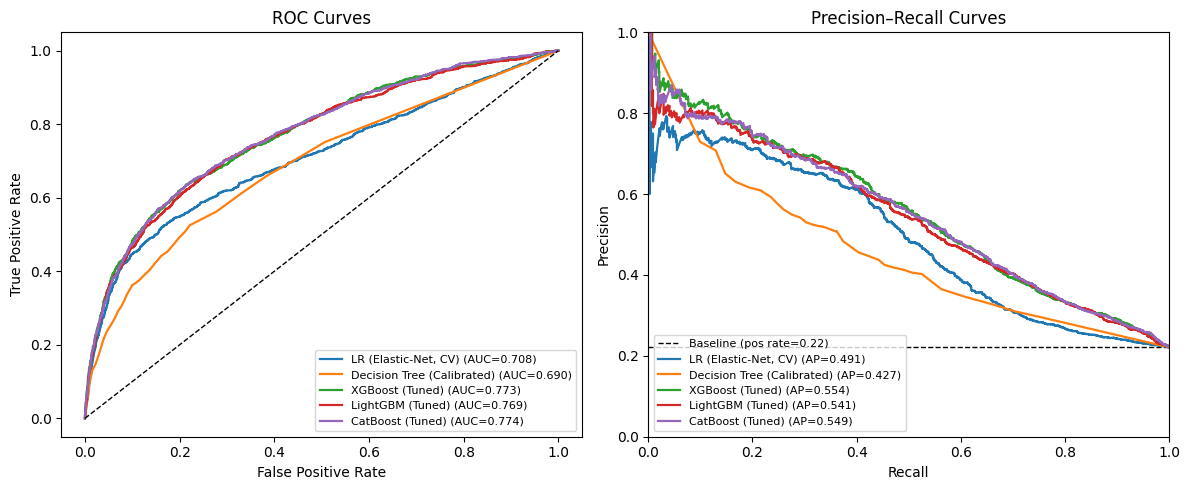

Model			AUC ROC		AP
CatBoost (Tuned)            	0.7739		0.5487
XGBoost (Tuned)             	0.7734		0.5542
LightGBM (Tuned)            	0.7688		0.5410
LR (Elastic-Net, CV)        	0.7083		0.4908
Decision Tree (Calibrated)  	0.6901		0.4270


In [18]:
# ==== 1) Imports ====
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

# ==== 2) Collect your models, names, and probabilities ====
models = {
    "LR (Elastic-Net, CV)": log_cv,
    "Decision Tree (Calibrated)": calibrated_dt,
    "XGBoost (Tuned)": xgb_tuned,
    "LightGBM (Tuned)": lgb_tuned,
    "CatBoost (Tuned)": cat_tuned,
}

probas = {
    "LR (Elastic-Net, CV)": y_prob_lr,
    "Decision Tree (Calibrated)": y_prob_cal,
    "XGBoost (Tuned)": y_prob_xgb_tuned,
    "LightGBM (Tuned)": y_prob_lgb_tuned,
    "CatBoost (Tuned)": y_prob_cat,
}

# ==== 3) Compute metrics for all models ====
roc_points = {}
pr_points  = {}
summary    = []  # (name, auc_roc, ap)

for name, y_prob in probas.items():
    # ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_roc = auc(fpr, tpr)
    roc_points[name] = (fpr, tpr, auc_roc)

    # PR
    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)
    pr_points[name] = (precision, recall, ap)

    summary.append((name, auc_roc, ap))

# ==== 4) Plot ROC and PR side-by-side ====
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- (A) ROC ---
ax = axes[0]
for name, (fpr, tpr, auc_roc) in roc_points.items():
    ax.plot(fpr, tpr, lw=1.6, label=f"{name} (AUC={auc_roc:.3f})")
ax.plot([0, 1], [0, 1], 'k--', lw=1)
ax.set_title("ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")
ax.legend(fontsize=8)

# --- (B) Precision–Recall ---
ax = axes[1]
pos_rate = np.mean(y_test)
ax.hlines(pos_rate, 0, 1, linestyles="dashed", colors="k", lw=1, label=f"Baseline (pos rate={pos_rate:.2f})")
for name, (prec, rec, ap) in pr_points.items():
    ax.plot(rec, prec, lw=1.6, label=f"{name} (AP={ap:.3f})")
ax.set_title("Precision–Recall Curves")
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.legend(fontsize=8, loc="lower left")

plt.tight_layout()
plt.show()

# ==== 5) (Optional) Print a compact summary table ====
print("Model\t\t\tAUC ROC\t\tAP")
for name, auc_roc, ap in sorted(summary, key=lambda x: x[1], reverse=True):
    print(f"{name:28s}\t{auc_roc:.4f}\t\t{ap:.4f}")
